In [1]:
#from plottable import Table
import pandas as pd
import matplotlib.pyplot as plt
from help_functions import collect_config_to_df, plot_common, plot_comparing_models, get_same_diff_df, show_plots, vizulaize_chunked, create_movie, plot_veff, plot_chunked_veff
import numpy as np
from scipy.stats import chi2_contingency



In [8]:
def chi_square_tests(df, target):
    for column in df.columns:
        if column != target:
            contingency_table = pd.crosstab(df[column], df[target])
            chi2, p, dof, expected = chi2_contingency(contingency_table)
            print(f"Chi-square test for {column} and {target}:")
            print(f"Chi-square statistic = {chi2}")
            print(f"p-value = {p}\n")

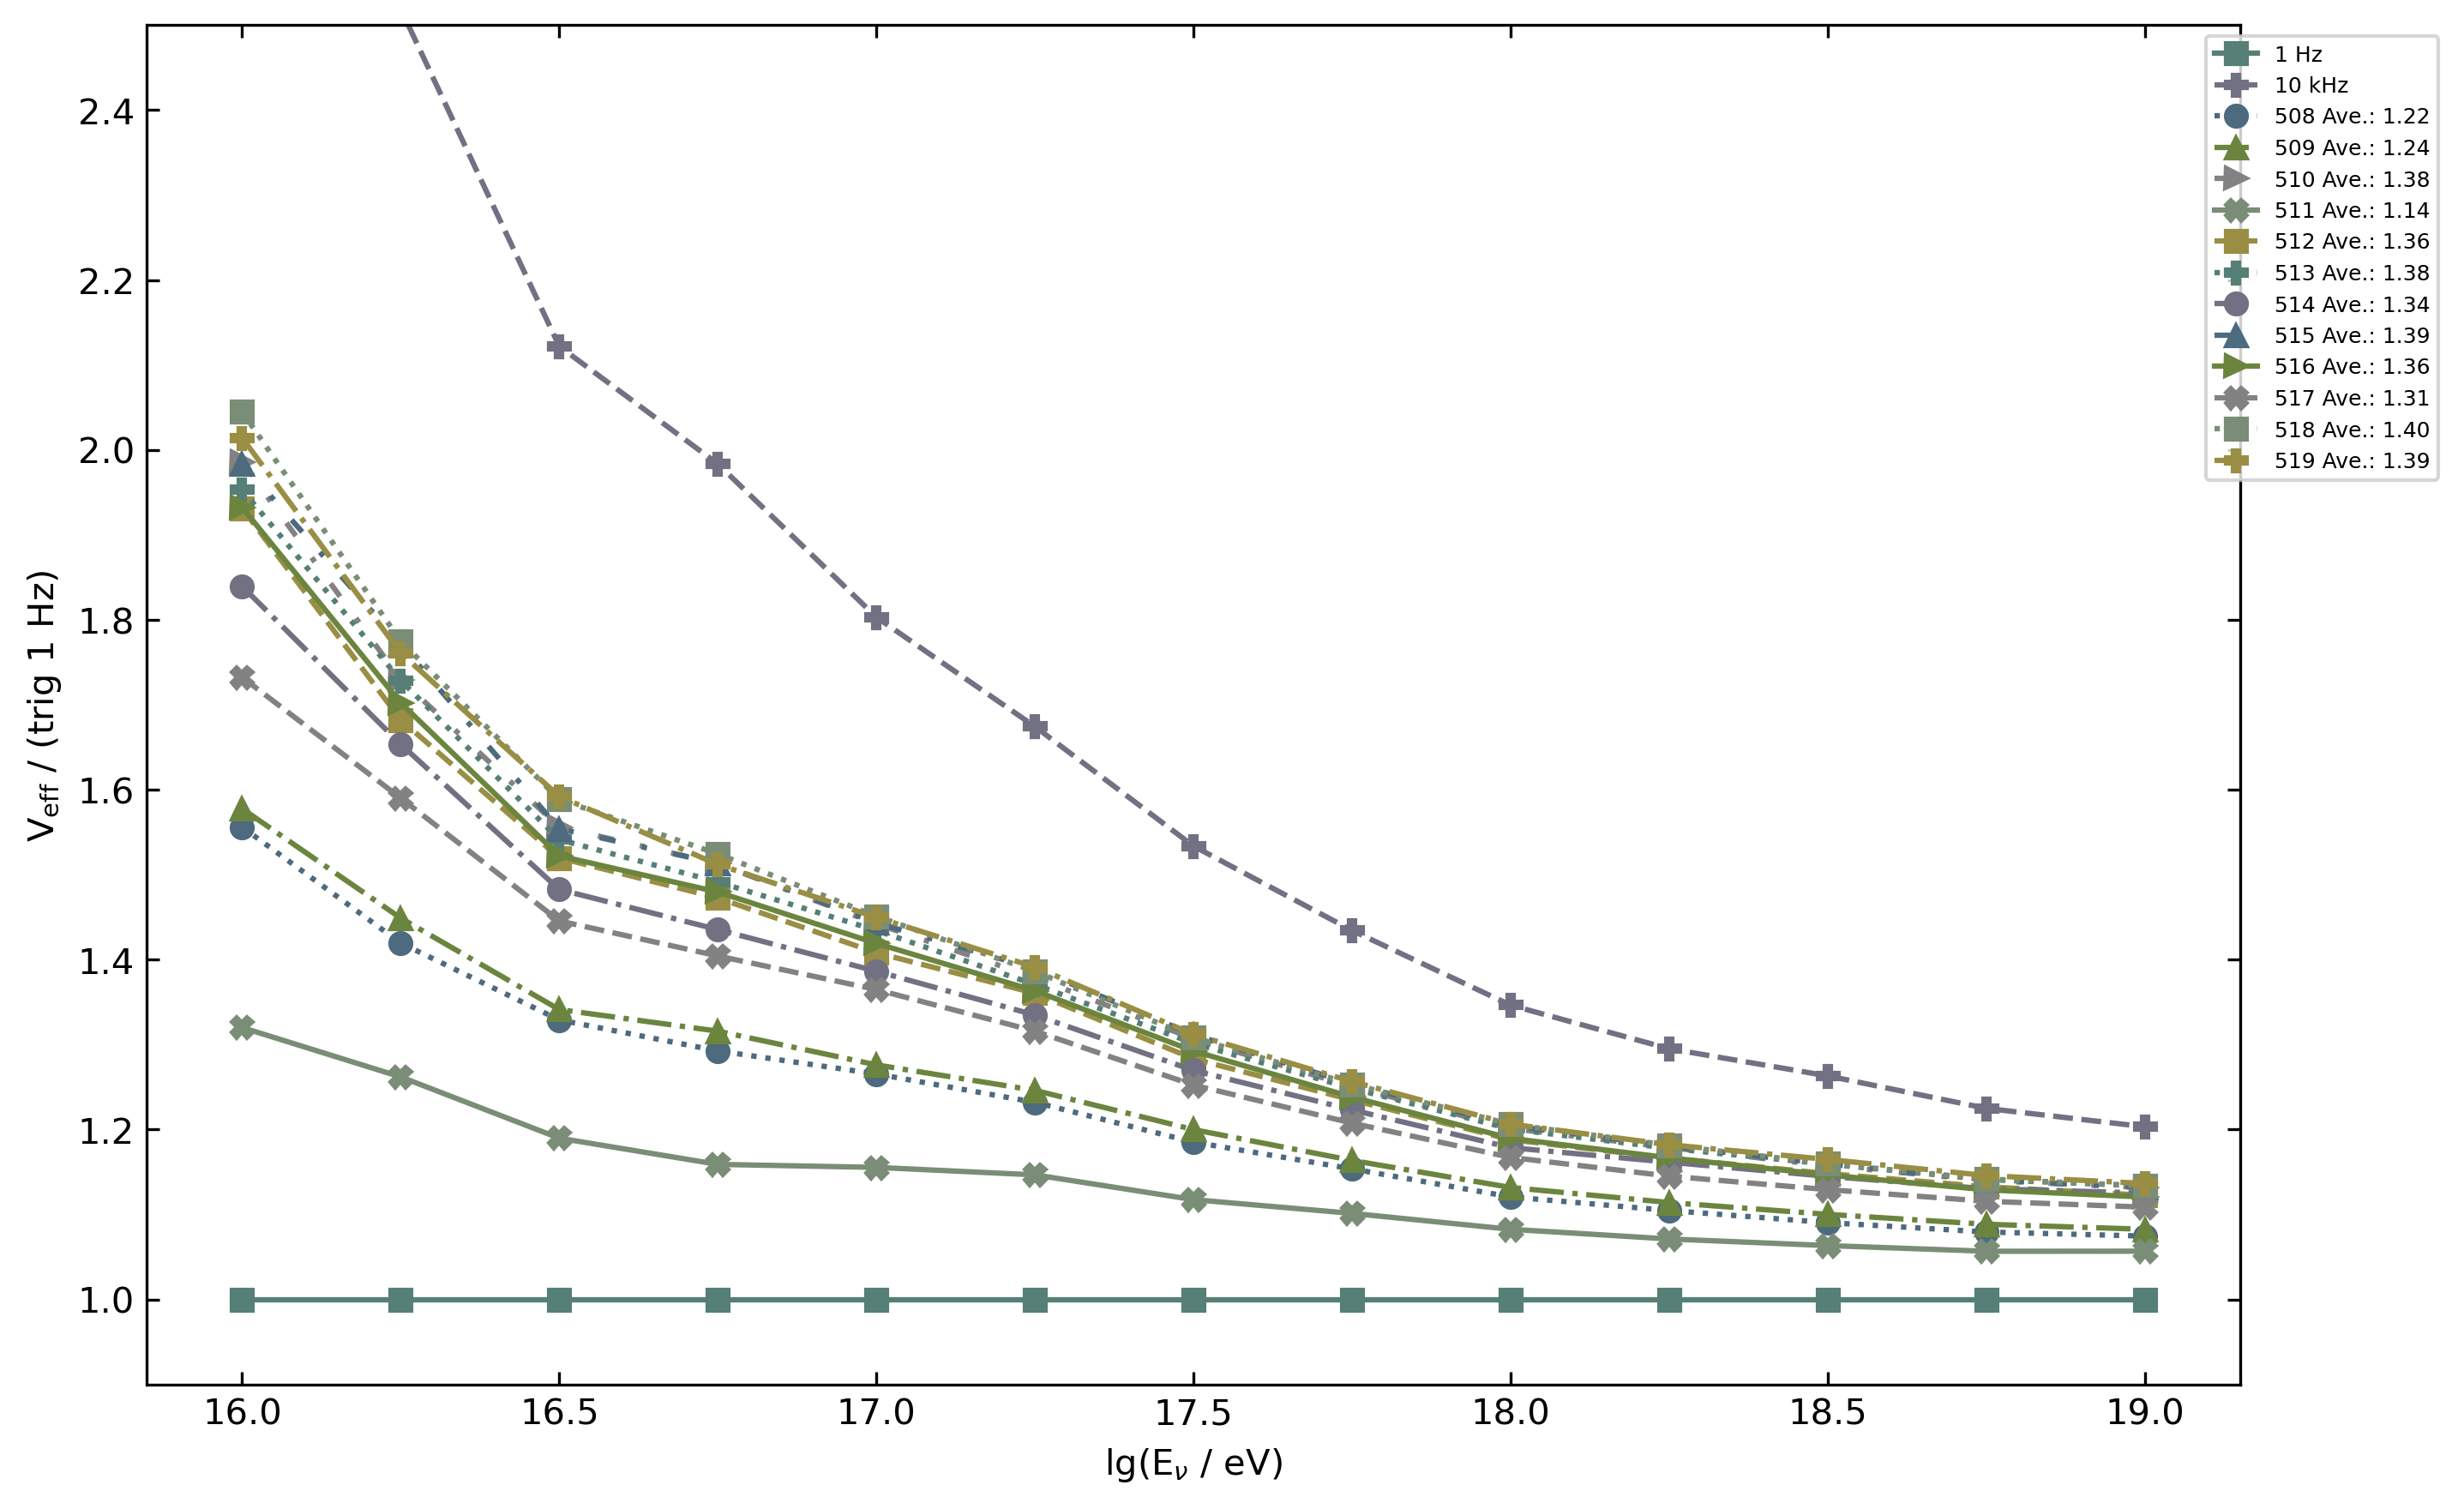

{'508': 1.2233852794497488, '509': 1.2374757190067585, '510': 1.3824764331114414, '511': 1.137159722037384, '512': 1.3577659108960871, '513': 1.375552636901858, '514': 1.3358387628462367, '515': 1.387521442792648, '516': 1.3616990736318957, '517': 1.3060938531405524, '518': 1.3965033343690736, '519': 1.3942107317751027}
[518 519 515 510 513 516 512 514 517 509 508 511]
[1.39650333 1.39421073 1.38752144 1.38247643 1.37555264 1.36169907
 1.35776591 1.33583876 1.30609385 1.23747572 1.22338528 1.13715972]


In [10]:
models = list(range(508,520))
#models = [256,296,297,298,299]
veff_files = []
for model in models:
    veff_files.append(f'/mnt/md0/halin/Models/model_{model}/plot/QuickVeffRatio_{model}_best.npz')

results = plot_veff(veff_files, plot_path='', y_max=2.5)
models = [int(key) for key in results.keys()]
values = list(results.values())
indices = np.argsort(-np.array(values))

# Use these indices to sort the models and values
models_sorted = np.array(models)[indices]
values_sorted = np.array(values)[indices]
print(models_sorted)
print(values_sorted)

Plot collections of noise reduction factors or roc curve

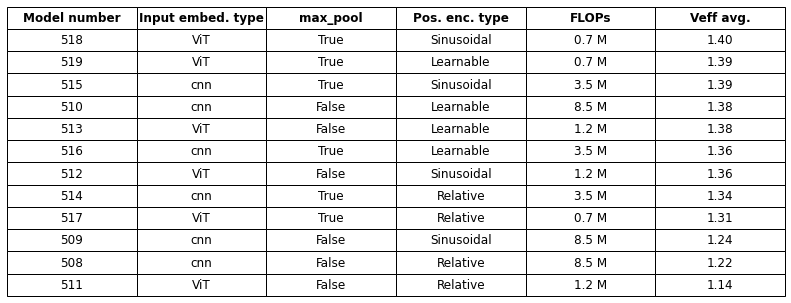

Chi-square test for model_num and Veff avg.:
Chi-square statistic = 132.0
p-value = 0.23290755488982084

Chi-square test for embed_type and Veff avg.:
Chi-square statistic = 12.0
p-value = 0.36364322051682674

Chi-square test for max_pool and Veff avg.:
Chi-square statistic = 12.0
p-value = 0.36364322051682674

Chi-square test for pos_enc_type and Veff avg.:
Chi-square statistic = 24.0
p-value = 0.3472294175541719

Chi-square test for FLOPs and Veff avg.:
Chi-square statistic = 84.0
p-value = 0.2738548573757371

model_num    0.599424
max_pool     0.490647
FLOPs       -0.256396
Veff avg.    1.000000
Name: Veff avg., dtype: float64


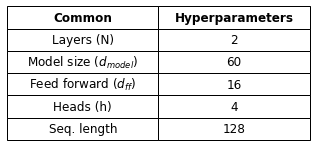

In [12]:
# model_path = '/home/hansalin/dl1/nuradio-analysis/configs/chunked/'
# models = [310,311,312,313,314,315]
model_path = '/mnt/md0/halin/Models/'
#models = list(range(250,274))
#models = [250,251]

df = collect_config_to_df(models, model_path=model_path, type_of_file='yaml')
df['Veff avg.'] = values

sort = True
col_width = 3.0
save = False
prefix = ''
# compare_keys = ['model_num', 'N', 'num_param', 'NSE_AT_10KNRF','MACs']
# compare_df = df[compare_keys]
df_same, df_diff = get_same_diff_df(df)

exclude_columns = [
    # 'activation',
    # 'batch_size',
    # 'decreas_factor',
    # 'dropout',
    # #'embed_type',
    'NSE_AT_10KNRF',
    'encoder_param',
    'num_param',
    # 'encoder_type',
    'final_param',
    # #'final_type',
    'input_param',
    # 'learning_rate',
    # 'location',
    # 'loss_function',
    'max_relative_position',
    # 'n_ant',
    # 'normalization',
    # #'pos_enc_type',
    'pos_param',
    # 'residual_type',
    # 'seq_len',
    # 'step_size',
    # 'encode_type',
    'training_time',
    'MACs'

]
if df_diff.empty:
    print('No common values')
    plot_comparing_models(df_same.iloc[[0]], 
                          row_height=0.35, 
                          col_width=col_width, 
                          sort=sort, 
                          exclude_columns=exclude_columns, 
                          save=save,
                          prefix=prefix
                          )
    exclude_columns = [
        'N',
        'MACs',
        'NSE_AT_10KNRF',
        'activation',
        'd_ff',
        'd_model',
        'embed_type',
        'encoder_param',
        'encoder_type',
        'final_param',
        'final_type',
        'h',
        'input_param',
        'location',
        
        'max_relative_position',
        'model_num',
        'n_ant',
        'normalization',
        'num_param',
        #'pos_enc_type',
        'pos_param',
        'residual_type',
        'encode_type',
        'training_time',
    ]
    plot_common(df_same.iloc[[0]] , 
                row_height=0.4, 
                col_width=col_width+0.5, 
                exclude_columns=exclude_columns, 
                save=save,
                prefix=prefix,
                )
else:
    df = plot_comparing_models(df_diff, 
                          row_height=0.35, 
                          col_width=col_width, 
                          sort=sort, 
                          exclude_columns=exclude_columns, 
                          save=save,
                          prefix=prefix,
                          )
    categorical_values = ['Pos. enc. type', 'Act. function', 'Input embed. type', 'Loss function', 'Projection type']
    chi_square_tests(df, 'Veff avg.')
    correlation = df.corr()['Veff avg.']
    print(correlation)  
    exclude_columns = [
    'activation',
    'batch_size',
    'decreas_factor',
    'dropout',
    'embed_type',
    'encoder_param',
    'encoder_type',
    'final_param',
    'final_type',
    'input_param',
    'num_param',
    'learning_rate',
    'location',
    'loss_function',
    'max_relative_position',
    'n_ant',
    'normalization',
    'pos_enc_type',
    'pos_param',
    'residual_type',
    # 'seq_len',
    'step_size',
    'encode_type',
    'training_time',
    'MACs',
    'NSE_AT_10KNRF',
    'max_pool',
    'FLOP',
    'step_size',
    'learning_rate',
    'projection_type',

]
    plot_common(df_same.iloc[[0]] , 
                row_height=0.4, 
                col_width=col_width + 0.5, 
                exclude_columns=exclude_columns, 
                save=save,
                prefix=prefix,
                )
# show_plots(model_num=200, search_string='roc')   